In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import camb
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.optimize
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

### Creating test observational data ("fake" data)

In [15]:
pars_test = camb.set_params(H0=67.4, 
                            ombh2=0.0224, 
                            omch2=0.120, 
                            redshifts=[0], 
                            kmax=10, 
                            As=2e-9, 
                            ns=0.96, 
                            halofit_version='mead2020_feedback', 
                            HMCode_A_baryon = 4.1, 
                            HMCode_eta_baryon = 0.75, 
                            HMCode_logT_AGN = 8.4)
results_test = camb.get_transfer_functions(pars_test)
kh_test, _, pk_test = results_test.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

kh_data = kh_test
pk_data = pk_test[0]

### Creating cosmology based on Planck2018 (no feedback) for reference

In [16]:
pars_planck_2018 = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.120,
                                  redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                                  halofit_version='mead2020_feedback',
                                  HMCode_A_baryon=0, HMCode_eta_baryon=0, HMCode_logT_AGN=-10)
results_planck_2018 = camb.get_transfer_functions(pars_planck_2018)
kh_planck2018, _, pk_planck2018 = results_planck_2018.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)

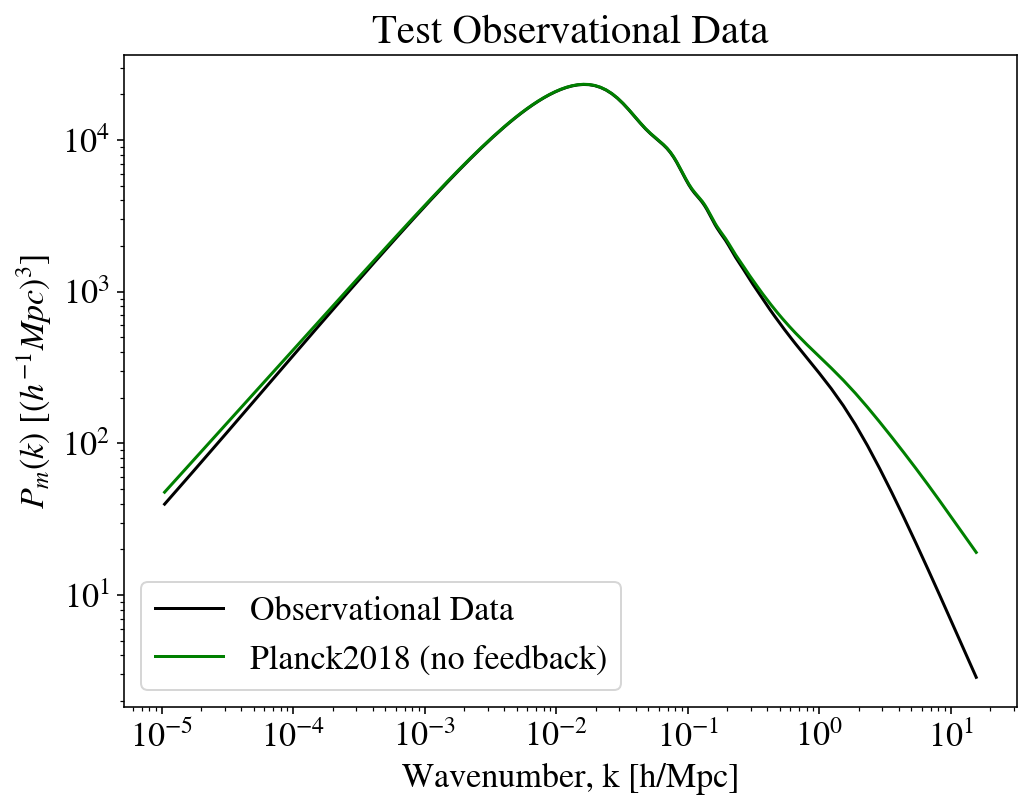

In [17]:
plt.figure(figsize=(8,6))
plt.loglog(kh_data, pk_data, 'k', label='Observational Data')
plt.loglog(kh_planck2018, pk_planck2018[0], 'g', label='Planck2018 (no feedback)')
plt.ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
plt.xlabel('Wavenumber, k [h/Mpc]')
plt.title('Test Observational Data')
plt.legend()
plt.show()

## Using scipy.optimize.curve_fit()

In [24]:
def baryon_model_mead(x_data, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([5, 1.3, 10])
popt_mead, pcov_mead = scipy.optimize.curve_fit(baryon_model_mead, kh_data, pk_data, guesses) 
popt_mead

array([ 4.85718294,  1.34519255, 10.        ])

In [26]:
def baryon_model_feedback(xdata, A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return pk[0]

guesses = np.array([5, 1.3, 10])
popt_feedback, pcov_feedback = scipy.optimize.curve_fit(baryon_model_feedback, kh_data, pk_data, guesses)
popt_feedback

array([5.        , 1.3       , 9.85927109])

In [36]:
bfp_cf = np.array([popt_mead[0], popt_mead[1], popt_feedback[2]])
bfp_cf

array([4.85718294, 1.34519255, 9.85927109])

## Using scipy.optimize.least_squares()

In [31]:
from scipy.optimize import least_squares

In [28]:
def baryon_feedback(baryons):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = baryons[0], 
                           HMCode_eta_baryon = baryons[1], 
                           HMCode_logT_AGN = baryons[2])
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]

def baryon_mead(baryons):
    pars = camb.set_params(H0=67.5, ombh2=0.022, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead', 
                           HMCode_A_baryon = baryons[0], 
                           HMCode_eta_baryon = baryons[1], 
                           HMCode_logT_AGN = baryons[2])
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]

In [33]:
def residuals_feedback(baryons, y_data, x_data):
    return y_data - baryon_feedback(baryons)[1]

def residuals_mead(baryons, y_data, x_data):
    return y_data - baryon_mead(baryons)[1]

In [35]:
guesses = np.array([5, 1.3, 10])

best_fit_mead = least_squares(residuals_mead, guesses, args=(pk_data, kh_data))
best_fit_mead.x

array([ 2.92023629,  1.6888665 , 10.        ])

In [37]:
best_fit_feedback = least_squares(residuals_feedback, guesses, args=(pk_data, kh_data))
best_fit_feedback.x

array([5.        , 1.3       , 9.29652159])

In [38]:
bfp_ls = np.array([best_fit_mead.x[0], best_fit_mead.x[1], best_fit_feedback.x[2]])
bfp_ls

array([2.92023629, 1.6888665 , 9.29652159])

## Plotting and comparing results

In [39]:
def baryon_model(A_baryon, eta_baryon, logT_AGN):
    pars = camb.set_params(H0=67.4, ombh2=0.0224, omch2=0.122, redshifts=[0], kmax=10, As=2e-9, ns=0.96, 
                           halofit_version='mead2020_feedback', 
                           HMCode_A_baryon = A_baryon, 
                           HMCode_eta_baryon = eta_baryon, 
                           HMCode_logT_AGN = logT_AGN)
    results = camb.get_transfer_functions(pars)
    kh, _ , pk = results.get_nonlinear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    return kh, pk[0]

<Figure size 432x288 with 0 Axes>

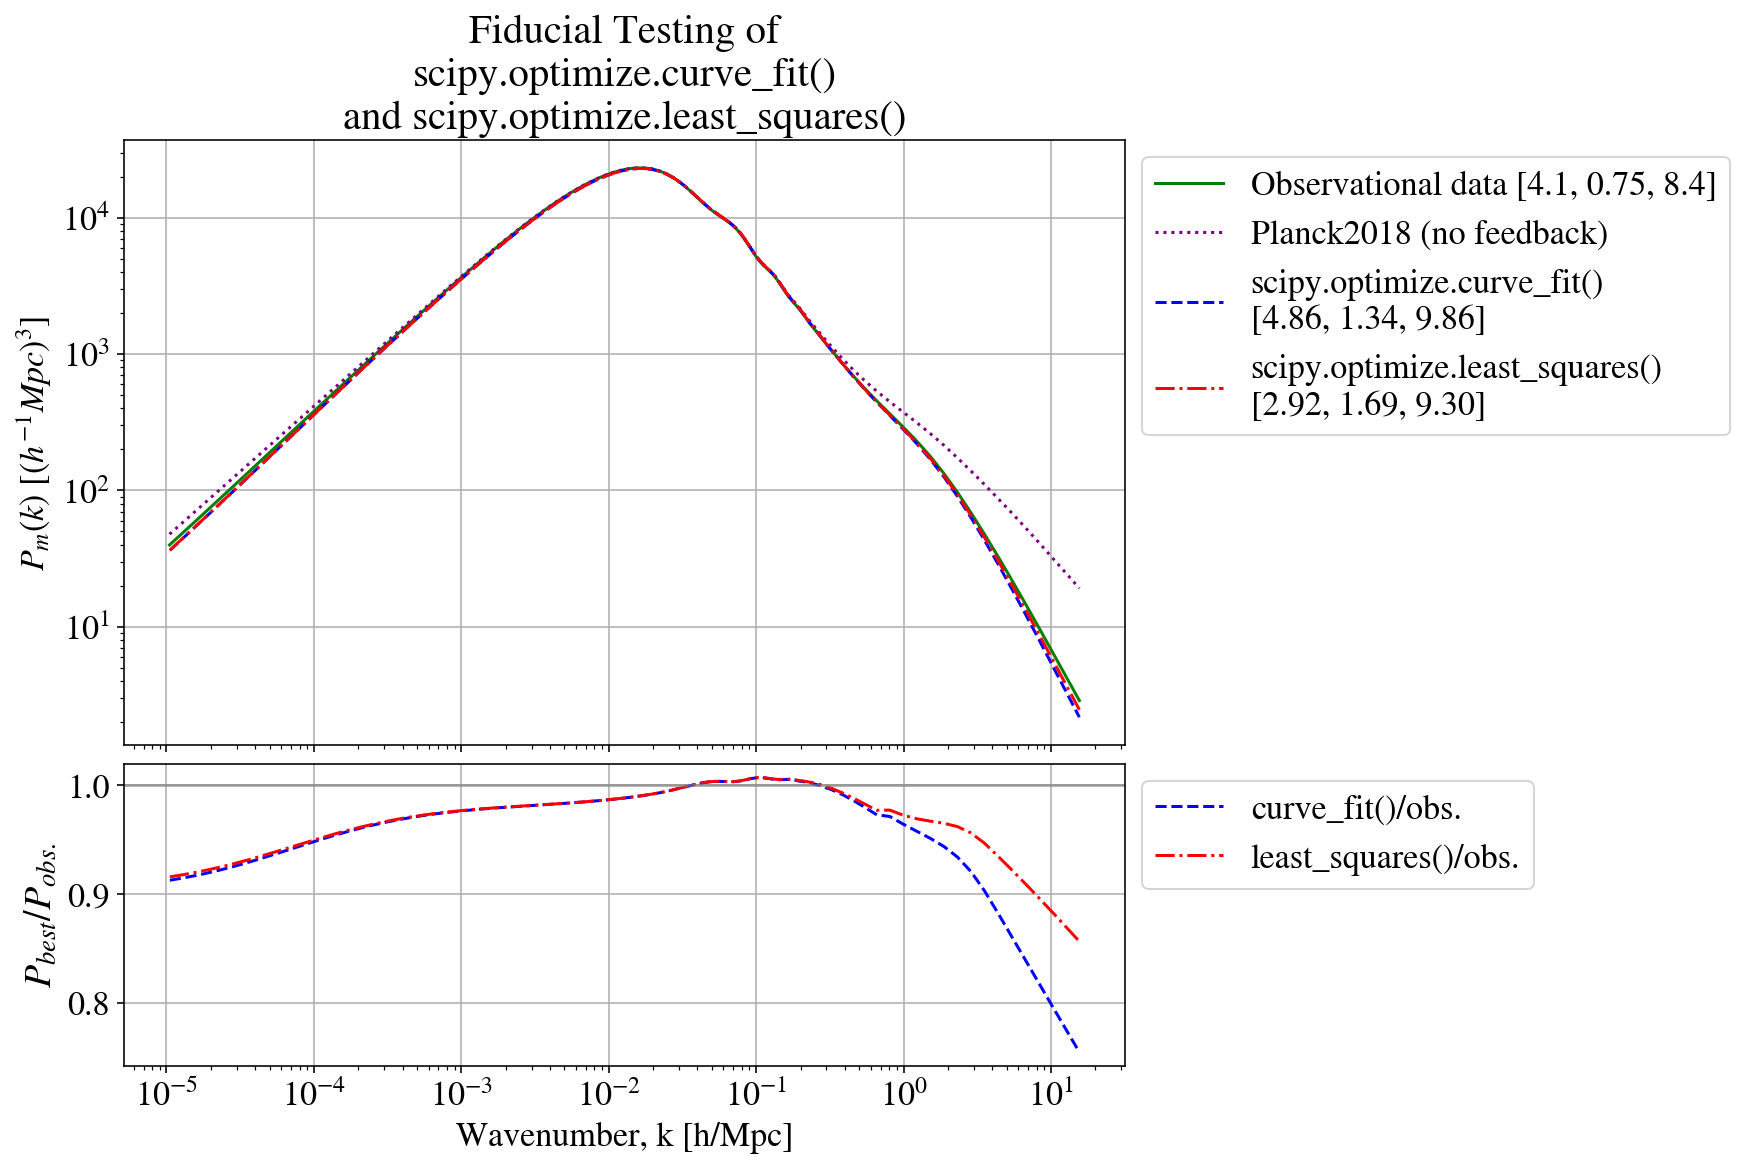

In [52]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, 
                               figsize=(12,8), 
                               constrained_layout=True, 
                               sharex=True, 
                               gridspec_kw={'height_ratios':[3, 1.5]})

ax0.loglog(kh_data, pk_data, 'green', label='Observational data [4.1, 0.75, 8.4]')
ax0.loglog(kh_planck2018, pk_planck2018[0], 'purple', linestyle=':', label='Planck2018 (no feedback)')
ax0.loglog(baryon_model(*bfp_cf)[0], baryon_model(*bfp_cf)[1], 'b', linestyle='--', label='scipy.optimize.curve_fit()\n[4.86, 1.34, 9.86]')
ax0.loglog(baryon_model(*bfp_ls)[0], baryon_model(*bfp_ls)[1], 'red', linestyle='-.', label='scipy.optimize.least_squares()\n[2.92, 1.69, 9.30]')

ax0.grid()
ax0.set_title('Fiducial Testing of\nscipy.optimize.curve_fit()\nand scipy.optimize.least_squares()')
ax0.set_ylabel('$P_m(k)$ [($h^{-1}Mpc)^3$]')
ax0.legend(bbox_to_anchor = (1, 1), loc='upper left')
#props = dict(boxstyle='round', facecolor='white')
#ax0.text(0.00001, 3000, 'Best fit parameters:\nA = {0:.3f}\neta = {1:.3f}\nlogT_AGN = {2:.3f}'.format(*best_fit_pieced))


ax1.semilogx(baryon_model(*bfp_cf)[0], baryon_model(*bfp_cf)[1]/pk_data, color='blue', linestyle='--', label='curve_fit()/obs.')
ax1.semilogx(baryon_model(*bfp_ls)[0], baryon_model(*bfp_ls)[1]/pk_data, color='red', linestyle='-.', label='least_squares()/obs.')
ax1.legend(bbox_to_anchor = (1, 1), loc='upper left')
ax1.axhline(1, color='grey', alpha=0.6)
ax1.set_ylabel('$P_{best}/P_{obs.}$', fontsize=19)
ax1.set_xlabel('Wavenumber, k [h/Mpc]')
ax1.grid()
plt.show()

